In [15]:
import numpy as np
import matplotlib.pyplot as plt
L=10
h1=0.005
N=int(2*L/h1)
H=np.zeros((N,N))
H[0][0]=1
H[N-1][N-1]=1

for i in range(1,N-1):
    H[i][i-1]=-0.5/h1**2
    H[i][i]=(1/h1**2)+V(-L+i*h1)
    H[i][i+1]=-0.5/h1**2
E=np.linalg.eigh(H)
v=np.transpose(E[1])
X=[-L+i*h1 for i in range(N)]
fig=plt.figure()
plt.axis([-L,L,-1,1])
plt.scatter(X,(v[2])**2/h1,s=1)
plt.show()


NameError: name 'V' is not defined

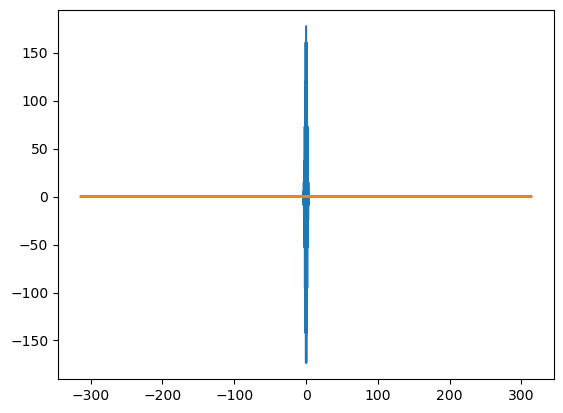

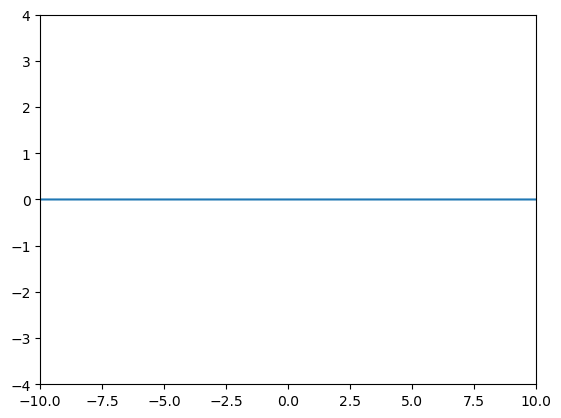

In [16]:
import numpy as np
import matplotlib.pyplot as plt
h=0.01
a=-10
b=10
t = np.arange(a,b,h)
#sp = np.fft.fft(np.sin(t))
#sp = np.fft.fft(t**2)
sp = np.fft.fft(np.exp(-t**2))
freq = np.fft.fftfreq(t.shape[-1])
k=(2*np.pi/h)*freq
plt.figure()
plt.plot(k, sp.real, k, sp.imag)
plt.show()
SP=np.fft.ifft(k**2*sp)
plt.figure()
plt.plot(t, SP.imag)
plt.axis([-10,10,-4,4])
plt.show()

In [64]:
class Solver:
    def __init__(self,L1,L2,h,V):
        self.L1=L1
        self.L2=L2
        self.h=h
        self.N=int((L2-L1) / h)
        self.V=V
        self.x=np.arange(L1,L2,h)
        self.H=np.zeros((self.N,self.N))
        self.values=np.zeros((self.N))
        self.vectors=np.zeros((self.N,self.N))
    
    def compute_H(self):
        D = self.V(self.x)+(1/self.h**2)
        d = (-0.5/self.h**2)*np.ones((self.N-1))
        self.H = np.diag(D)+np.diag(d,-1)+np.diag(d,1)
        return self
    
    def compute_eigen(self):
        E = np.linalg.eigh(self.H)
        self.values = E[0]
        self.vectors = np.transpose(E[1])/(self.h)**0.5
        return self
    
    def compute_all(self):
        self.compute_H().compute_eigen()
        return self
    
    def mean_x(self,f,n):
        F = f(self.x)
        psi = self.vectors[n]
        return self.h*np.dot(psi**2,F)
    
    def plot(self,n):
        fig=plt.figure()
        plt.grid(True)
        plt.plot(self.x,self.vectors[n])
        plt.show()
    

        

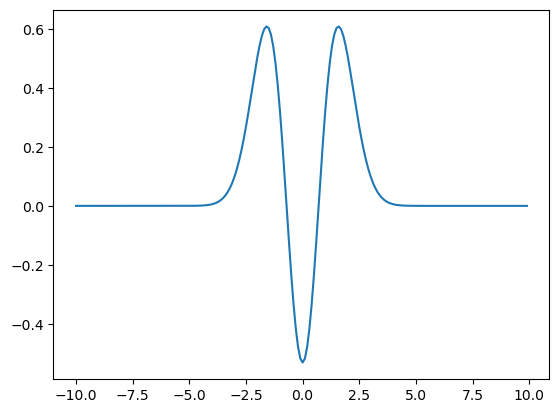

In [65]:
def V_osc(x):
    return x**2/2
solv=Solver(-10,10,0.1,V_osc)
solv.compute_all()
#solv.plot(0)
fig=plt.figure()
#plt.plot(solv.x,solv.vectors[1])
plt.plot(solv.x,psi(2,solv.x))
plt.show()
#print(Solv.mean_x(V_osc,0))



In [345]:
def psi(n,x):
    N = np.zeros(n+1)
    N[n] = 1
    H = np.polynomial.hermite.Hermite(N)
    Norm = 2**(-0.5 * n) * np.pi**-0.25 * (np.math.factorial(n))**-0.5 
    wf = Norm * np.exp(-x**2/2) * H(x)
    return wf

class Solver_Herm:
    def __init__(self,L1,L2,h,n_herm,V,T):
        self.L1 = L1
        self.L2 = L2
        self.h = h
        self.N = int((L2-L1) / h)
        self.V = V
        self.T = T
        self.n_herm = n_herm
        self.x = np.arange(L1,L2,h)
        self.p=(2*np.pi/self.h) * np.fft.fftfreq(self.x.shape[0])
        self.H = np.zeros((self.n_herm,self.n_herm))
        self.values = np.zeros((self.n_herm))
        self.vectors_herm = np.zeros((self.n_herm,self.n_herm))
        self.vectors_x = np.zeros((self.n_herm,self.N))
        self.vectors_p = np.zeros((self.n_herm,self.N))
        self.PSI = np.array([psi(n,self.x) for n in range(self.n_herm)])
        
    def op_H(self,F_x):
        F_p = np.fft.fft(F_x)
        p = (2*np.pi/self.h) * np.fft.fftfreq(F_x.shape[0])
        TF_p = self.T(p) * F_p
        TF_x = np.fft.ifft(TF_p).real
        HF=TF_x + self.V(self.x) * F_x
        return HF
        
    
    def compute_H(self):
        I=np.eye(self.n_herm)
        for i in range(self.n_herm):
            for j in range(self.n_herm):
                self.H[i][j] = self.h * np.dot(self.PSI[i],self.op_H(self.PSI[j]))
        return self
    
    def compute_eigen(self):
        E = np.linalg.eigh(self.H)
        self.values = E[0]
        self.vectors_herm = np.transpose(E[1])
        return self
    
    def x_rep(self):
        self.vectors_x = np.dot(self.vectors_herm,self.PSI)
        return self
    
    def p_rep(self):
        PSI_p = self.h *(2*np.pi)**-0.5 * np.fft.fft(self.PSI,axis=1)
        self.vectors_p = np.dot(self.vectors_herm,np.abs(PSI_p))
        return self
        
    def compute_all(self):
        self.compute_H().compute_eigen().x_rep().p_rep()
        return self
    
    def mean_x(self,f,n=0):
        F = f(self.x)
        psi_x = self.vectors_x[n]
        return self.h * np.dot(psi_x**2,F)
    
    def mean_p(self,f,n=0):
        F = f(self.p)
        psi_p = self.vectors_p[n]
        return (2*np.pi/(self.L2-self.L1)) * np.dot(psi_p**2,F)
    
    def get_rho(self,beta):
        E = np.exp(-beta*(self.values-self.values[0]))
        rho = np.dot(E,self.vectors_x**2)/np.sum(E)
        return rho
    
    def plot(self,n):
        fig=plt.figure()
        plt.grid(True)
        plt.plot(self.x,self.vectors_x[n])
        plt.show()
    

        

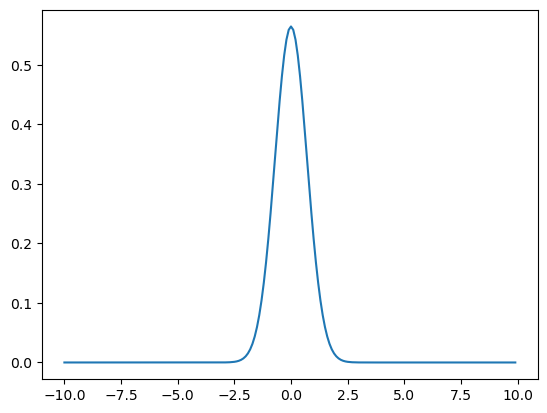

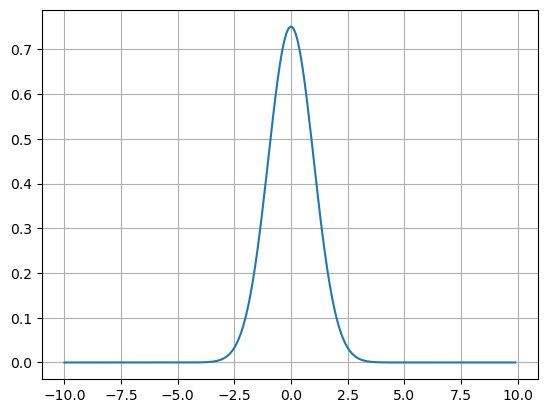

0.49999999999999833


In [346]:
def V_osc(x):
    return x**2/2
def T(p):
    return p**2/2
def one(x):
    return np.ones((x.shape[0]))
def x2(x):
    return x**2

solv=Solver_Herm(-10,10,0.1,2,V_osc,T)
solv.compute_all()
plt.figure()
#plt.scatter(solv.p,np.abs(np.fft.fft(psi(0,solv.x))))
#plt.scatter(solv.p,solv.vectors_p[0])
plt.plot(solv.x,solv.get_rho(10))
#plt.axis([-10,10,0,0.8])
plt.show()
solv.plot(0)
print(solv.mean_p(x2))

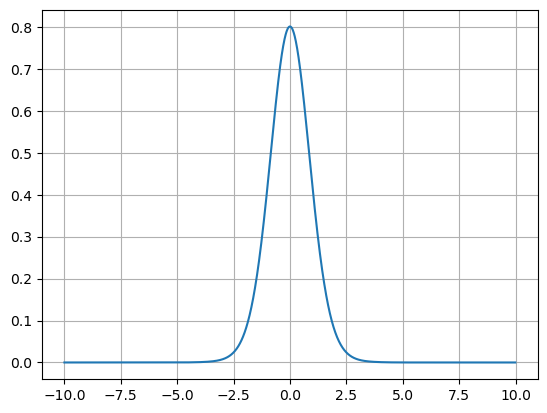

In [331]:
def T_rel(p):
    return (1+p**2)**0.5
solv_rel = Solver_Herm(-10,10,0.01,10,V_osc,T_rel)
solv_rel.compute_all()
solv_rel.plot(0)

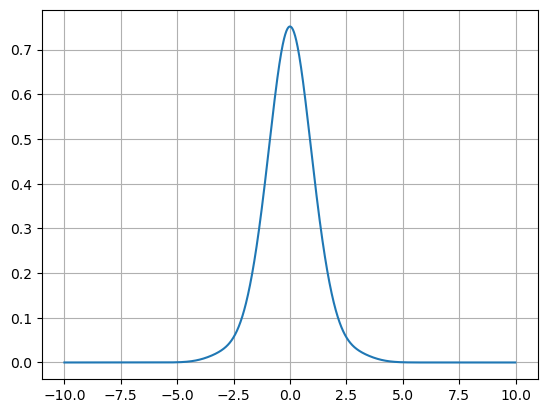

0.27243787190358815


In [332]:
def T_ur(p):
    return np.abs(p)
solv_ur = Solver_Herm(-10,10,0.01,10,V_osc,T_ur)
solv_ur.compute_all()
solv_ur.plot(0)
print(solv_ur.mean_x(V_osc,0))

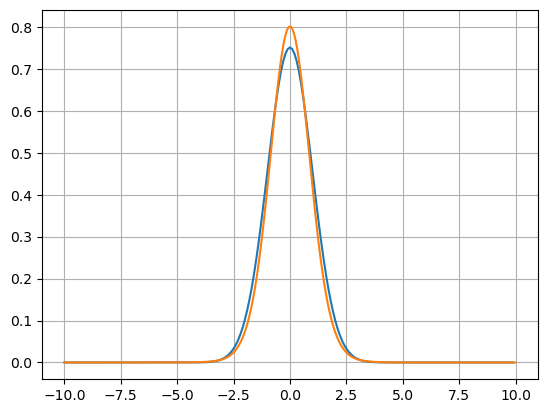

0.20018343608202344


In [333]:
plt.figure()
plt.plot(solv.x,solv.vectors_x[0])
plt.plot(solv_rel.x,solv_rel.vectors_x[0])
plt.grid(True)
plt.show()
print(solv_rel.mean_x(V_osc,0))

In [365]:
from math import gamma
def get_V_morse(alpha):
    def V_morse(x):
        y = np.exp(-alpha * x)-1
        return 0.5*(y**2-1)
    return V_morse

def theor_Psi2(alpha,x):
        N = 2**(2 / alpha - 1) * (2-alpha)/( (alpha ** (2/alpha - 1)) * gamma(2/alpha))
        power = (-2 / alpha) * np.exp(-alpha * x) - (2-alpha) * x
        P=N*np.exp(power)
        return P


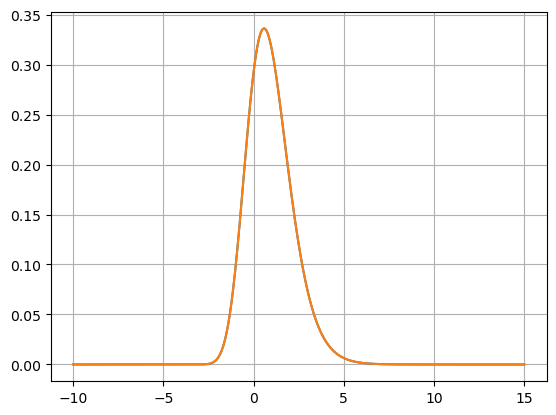

In [366]:
from math import gamma
"""
A=0.5
def V_morse(x):
    alpha = A
    y = np.exp(-alpha * x)-1
    return 0.5*(y**2-1)

def theor_Psi2(alpha,x):
        N = 2**(2 / alpha - 1) * (2-alpha)/( (alpha ** (2/alpha - 1)) * gamma(2/alpha))
        power = (-2 / alpha) * np.exp(-alpha * x) - (2-alpha) * x
        P=N*np.exp(power)
        return P
"""

solv_morse = Solver(-10,15,0.005,get_V_morse(0.5))
solv_morse.compute_all()
plt.figure()
plt.grid(True)
plt.plot(solv_morse.x,solv_morse.vectors[0]**2)
plt.plot(solv_morse.x,theor_Psi2(A,solv_morse.x))
plt.show()

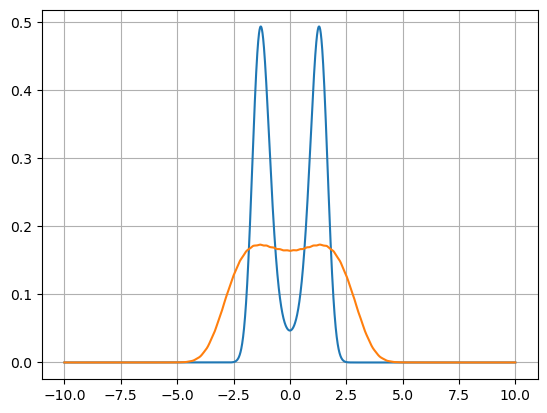

In [358]:
def Vtw(x):
    x0 = 1.41
    return (x**2-x0**2)**2
solv_tw = Solver_Herm(-10,10,0.005,60,Vtw,T)
solv_tw.compute_all()
plt.figure()
plt.grid(True)
plt.plot(solv_tw.x,solv_tw.vectors_x[0]**2)
plt.plot(solv_tw.x,solv_tw.get_rho(1/64))
plt.show()

In [336]:
ones=np.ones((10))
print(np.fft.fft(ones))

[10.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j]


In [ ]:
#self.vectors_p = np.array(list(map(lambda x:x*np.dot(x,x)**-0.5,self.vectors_p)))